In [1]:
!pip install ultralytics opencv-python matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd

In [23]:
# -----------------------------
# Load YOLOv8 Pretrained Model
# -----------------------------
# Using YOLOv8n (nano) for fast inference.
# You can switch to 'yolov8s.pt' or larger models for higher accuracy.
model = YOLO('yolov8n.pt')

In [24]:
# -----------------------------
# Load Input Images
# -----------------------------
# Replace paths with your own images
img_paths = ['/content/asm-1.jpg', '/content/asm-2.jpg']

# Read images using OpenCV and convert to RGB for matplotlib
images = [cv2.imread(p) for p in img_paths]
images = [cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in images]

# -----------------------------
# Detect Persons Using YOLOv8
# -----------------------------
# Run YOLOv8 detection on all images
results = model(images)


0: 640x640 1 person, 1 bicycle, 173.4ms
1: 640x640 1 person, 1 skateboard, 173.4ms
Speed: 3.8ms preprocess, 173.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
# -----------------------------
# Helper Function: Apply GrabCut
# -----------------------------
def apply_grabcut(image, rect, iterations=5):
    """
    Apply GrabCut segmentation given an initial bounding rectangle.

    Args:
        image (ndarray): Input RGB image.
        rect (tuple): Rectangle (x, y, w, h) around object.
        iterations (int): Number of GrabCut iterations.

    Returns:
        mask (ndarray): Internal GrabCut mask.
        fg_image (ndarray): Segmented foreground image.
        overlay (ndarray): Foreground overlaid on original image.
        fg_mask (ndarray): Binary mask of foreground.
    """
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Run GrabCut algorithm
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)

    # Extract foreground mask
    fg_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    fg_image = image * fg_mask[:, :, np.newaxis]

    # Create overlay
    overlay = image.copy()
    overlay[fg_mask == 0] = 0

    return mask, fg_image, overlay, fg_mask

# -----------------------------
# Helper Function: Compute Metrics
# -----------------------------
def compute_metrics(fg_mask, prev_mask=None):
    """
    Compute foreground area, ratio, and IoU with previous mask.

    Args:
        fg_mask (ndarray): Binary foreground mask of current iteration.
        prev_mask (ndarray or None): Binary mask of previous iteration.

    Returns:
        fg_area (int): Number of foreground pixels.
        fg_ratio (float): Foreground pixels / total pixels.
        iou (float or None): IoU with previous mask (if provided).
    """
    fg_area = fg_mask.sum()
    fg_ratio = fg_area / fg_mask.size
    iou = None
    if prev_mask is not None:
        intersection = np.logical_and(prev_mask, fg_mask).sum()
        union = np.logical_or(prev_mask, fg_mask).sum()
        iou = intersection / union if union != 0 else 0
    return fg_area, fg_ratio, iou

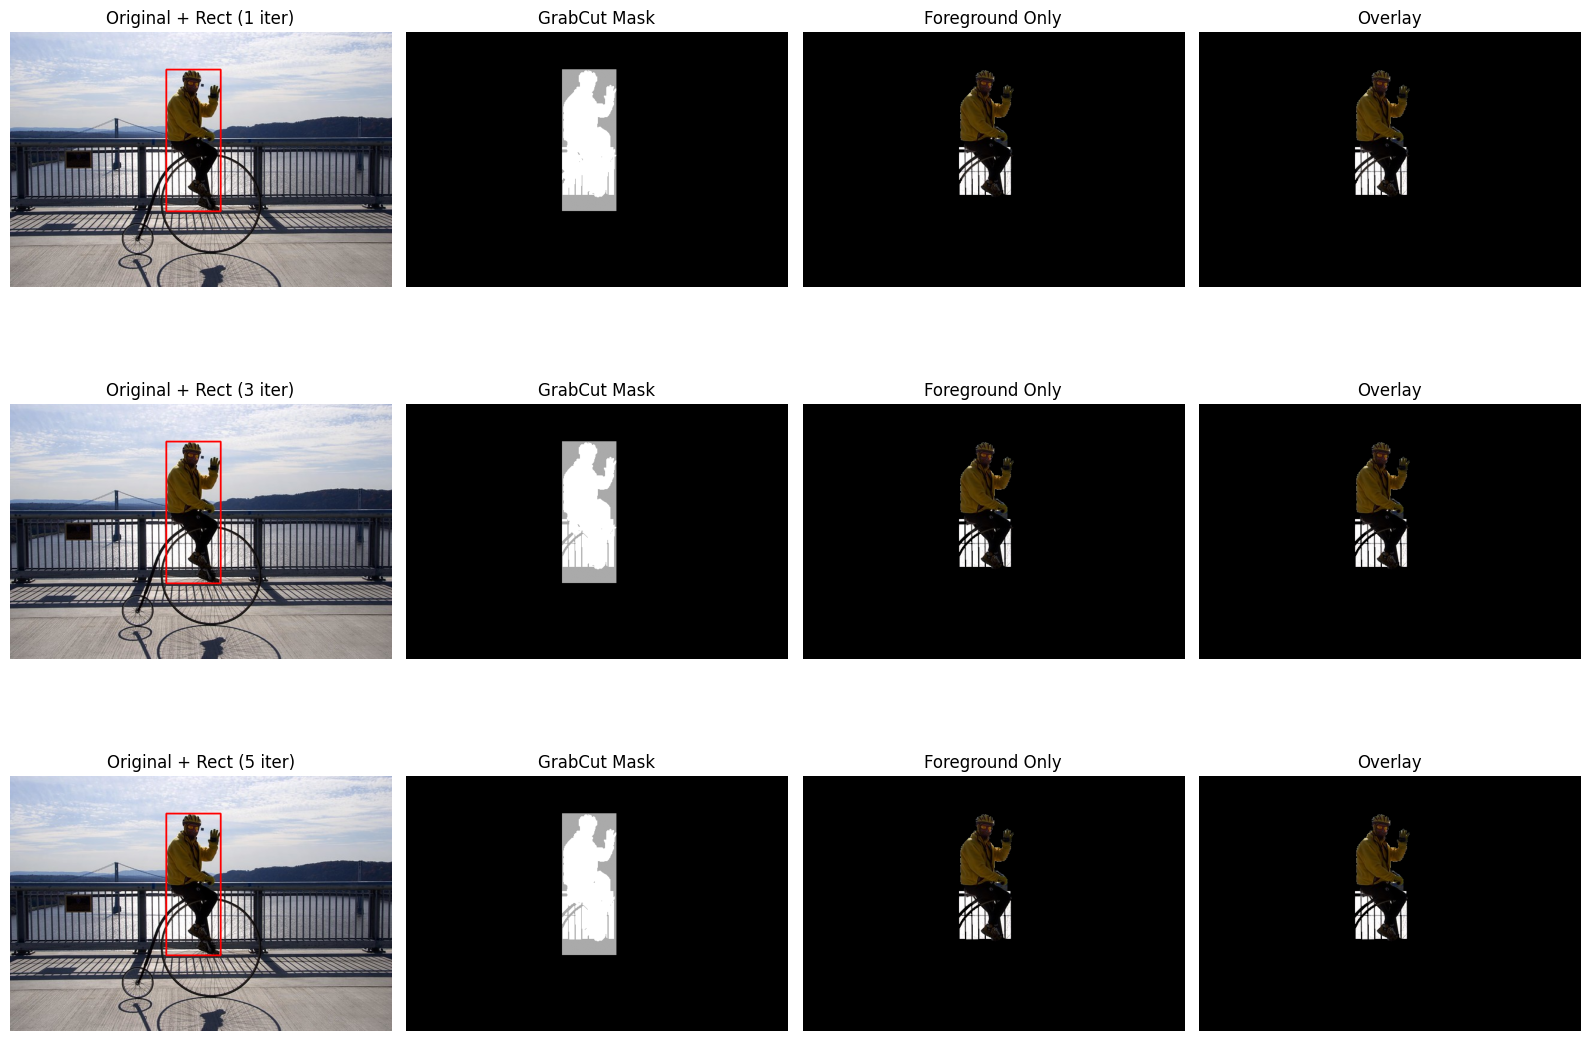

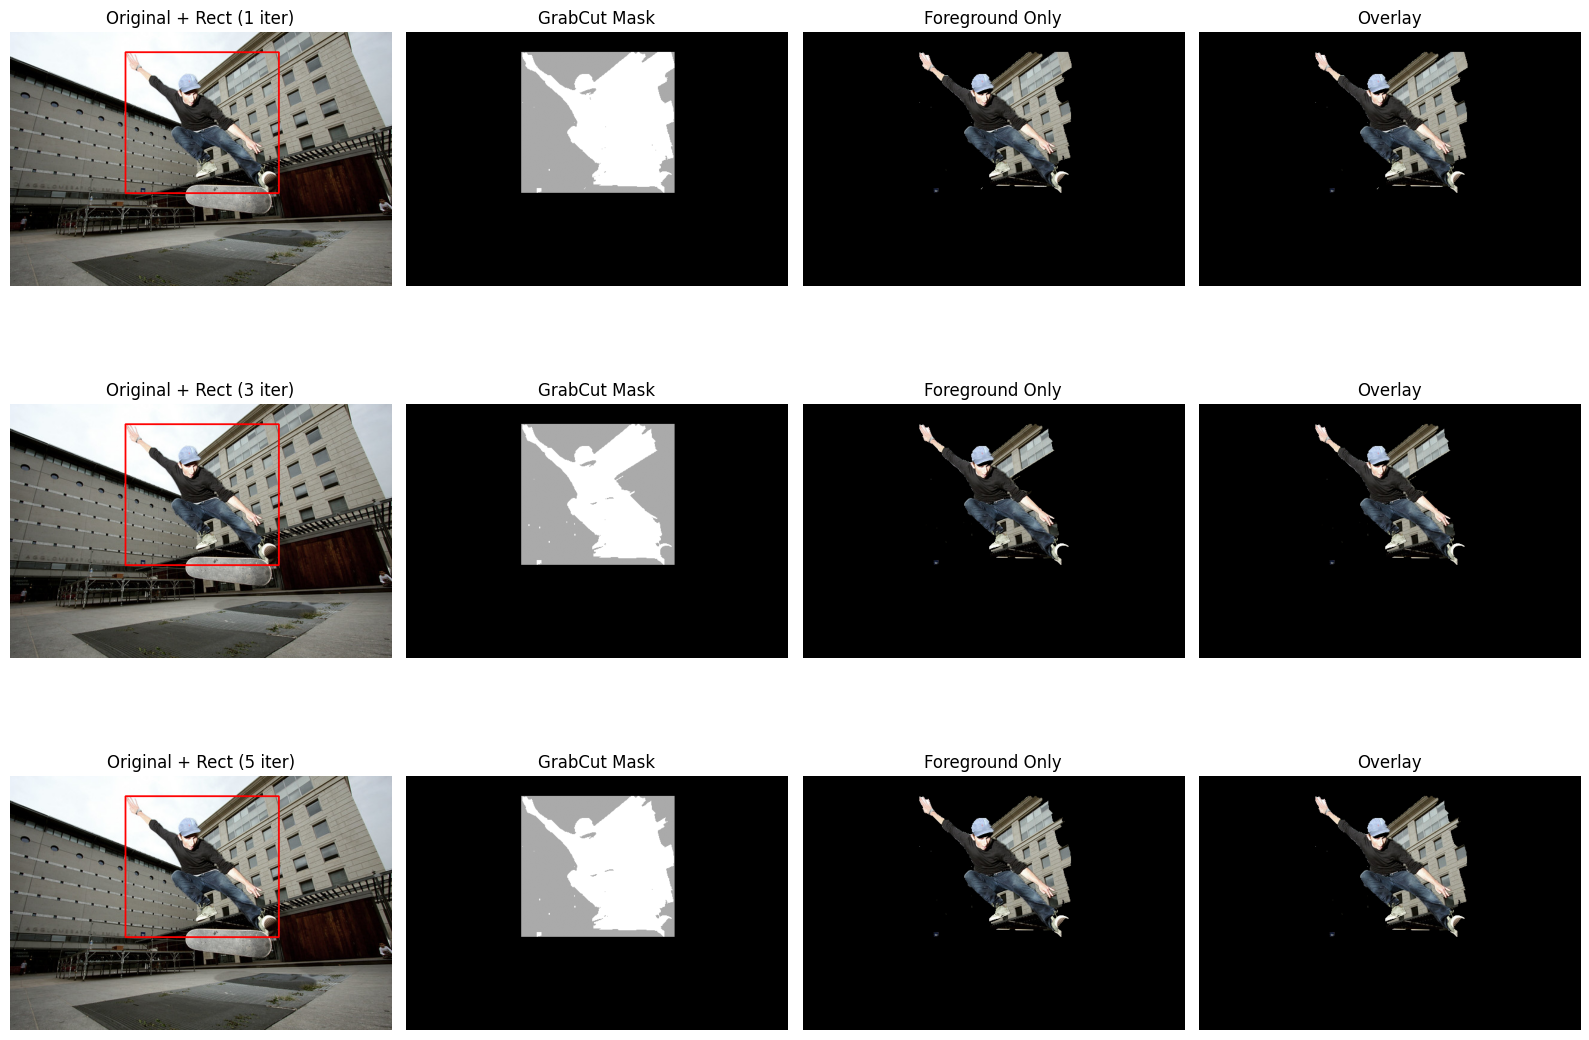

In [26]:
# -----------------------------
# Run GrabCut and Collect Metrics
# -----------------------------
iterations_list = [1, 3, 5]
metrics = []

for img_idx, (img, res) in enumerate(zip(images, results)):
    # Extract person bounding boxes
    boxes = [box.astype(int) for box, cls_id in zip(res.boxes.xyxy.cpu().numpy(),
                                                     res.boxes.cls.cpu().numpy().astype(int))
             if model.names[cls_id] == 'person']
    if len(boxes) == 0:
        print(f"No person detected in {img_paths[img_idx]}")
        continue

    # Select first bounding box
    x1, y1, x2, y2 = boxes[0]
    rect = (x1, y1, x2 - x1, y2 - y1)

    prev_mask = None
    fig, axes = plt.subplots(len(iterations_list), 4, figsize=(16, 4*len(iterations_list)))

    for row, iters in enumerate(iterations_list):
        mask, fg_img, overlay, fg_mask = apply_grabcut(img, rect, iterations=iters)

        # Compute metrics
        fg_area, fg_ratio, iou = compute_metrics(fg_mask, prev_mask)
        prev_mask = fg_mask.copy()

        metrics.append({
            'Image': img_paths[img_idx],
            'Iteration': iters,
            'Foreground Pixels': fg_area,
            'Foreground Ratio': round(fg_ratio, 3),
            'IoU Previous': round(iou, 3) if iou is not None else '-'
        })

        # Visualize results
        ax = axes[row, 0] if len(iterations_list) > 1 else axes[0]
        img_rect = img.copy()
        cv2.rectangle(img_rect, (x1, y1), (x2, y2), (255, 0, 0), 2)
        ax.imshow(img_rect)
        ax.axis('off')
        ax.set_title(f"Original + Rect ({iters} iter)")

        ax = axes[row, 1] if len(iterations_list) > 1 else axes[1]
        ax.imshow(mask, cmap='gray')
        ax.axis('off')
        ax.set_title("GrabCut Mask")

        ax = axes[row, 2] if len(iterations_list) > 1 else axes[2]
        ax.imshow(fg_img)
        ax.axis('off')
        ax.set_title("Foreground Only")

        ax = axes[row, 3] if len(iterations_list) > 1 else axes[3]
        ax.imshow(overlay)
        ax.axis('off')
        ax.set_title("Overlay")

    plt.tight_layout()
    plt.show()

In [27]:
# -----------------------------
# Convert Metrics to DataFrame
# -----------------------------
df_metrics = pd.DataFrame(metrics)
df_metrics
# Optionally, export metrics to CSV for report
# df_metrics.to_csv("grabcut_metrics.csv", index=False)

,Image,Iteration,Foreground Pixels,Foreground Ratio,IoU Previous
0,/content/asm-1.jpg,1,14208,0.052,-
1,/content/asm-1.jpg,3,13705,0.050,0.964
2,/content/asm-1.jpg,5,13757,0.050,0.988
3,/content/asm-2.jpg,1,31999,0.117,-
4,/content/asm-2.jpg,3,23647,0.087,0.736
5,/content/asm-2.jpg,5,30614,0.112,0.77


## Graph Cut Segmentation Results

### Visualization Explanation

1. **Original + Rect**  
   The original image with the bounding box used to initialize the GrabCut algorithm.  
   This rectangle defines the region where the algorithm searches for foreground (person) and background pixels.

2. **GrabCut Mask**  
   The internal mask produced by the GrabCut algorithm.  
   - White areas represent pixels classified as foreground (definite or probable).  
   - Dark areas represent background pixels.  
   This mask is used internally to guide the segmentation.

3. **Foreground Only**  
   The extracted foreground object (person) after segmentation.  
   All background pixels are removed (set to black), isolating the object from the scene.

4. **Overlay**  
   The segmented foreground object overlaid on the original image.  
   This helps visualize how well the foreground fits within the original context while masking out the background.


### Metrics Explanation

1. **Image**  
   - Name of the input image.  

2. **Iteration**  
   - Number of GrabCut iterations performed. Higher iterations usually refine object boundaries.  

3. **Foreground Pixels**  
   - Total number of pixels classified as foreground. Provides a measure of object size in pixels.  
   - **Formula:**

$$
\text{Foreground Pixels} = \sum_{i,j} M(i,j)
$$

where $M(i,j) = 1$ if pixel $(i,j)$ is classified as foreground, otherwise 0.  

4. **Foreground Ratio**  
   - Ratio of foreground pixels to total image pixels. Normalizes object size across different image resolutions.  
   - **Formula:**

$$
\text{Foreground Ratio} = \frac{\text{Foreground Pixels}}{\text{Total Image Pixels}} = \frac{\sum_{i,j} M(i,j)}{H \times W}
$$

where $H$ and $W$ are the image height and width.  

5. **IoU Previous**  
   - Intersection over Union (IoU) between the current iteration mask and the previous iteration mask.  
   - Values close to 1 indicate little change between iterations, while lower values indicate refinement.  
   - The first iteration is marked as `-` because there is no previous mask to compare.  
   - **Formula:**

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum_{i,j} A(i,j) \cdot B(i,j)}{\sum_{i,j} [A(i,j) + B(i,j) - A(i,j) \cdot B(i,j)]}
$$

where $A$ is the previous mask and $B$ is the current mask, with foreground pixels = 1 and background pixels = 0.

---

### Results Interpretation

The table shows segmentation results for two images across multiple iterations:

**asm-1.jpg** demonstrates high stability:
- Foreground pixels remain consistent (~13,700-14,200 pixels) across iterations
- Foreground ratio stays constant at approximately 0.050-0.052 (5% of the image)
- Very high IoU values (0.964 and 0.988) indicate minimal changes between iterations, suggesting the algorithm converged quickly to a stable segmentation

**asm-2.jpg** shows more variability:
- Foreground pixels fluctuate more significantly (23,647-31,999 pixels)
- Foreground ratio ranges from 0.087 to 0.117 (8.7%-11.7% of the image)
- Lower IoU values (0.736 and 0.77) indicate more substantial refinements between iterations, suggesting a more complex segmentation task or less stable convergence
- The object occupies approximately twice the area compared to asm-1.jpg

The difference in IoU values between the two images suggests that asm-1.jpg contains a more clearly defined object with cleaner boundaries, while asm-2.jpg may have more ambiguous regions or complex edges that require more iterative refinement.